In [1]:
import SmallNetwork
import NetGraphics
import numpy as np

In [7]:
network = SmallNetwork.SmallNetwork(20, 4, 0.2)

1 3
17 12
16 13
17 5
8 15
10 8
17 10
0 18


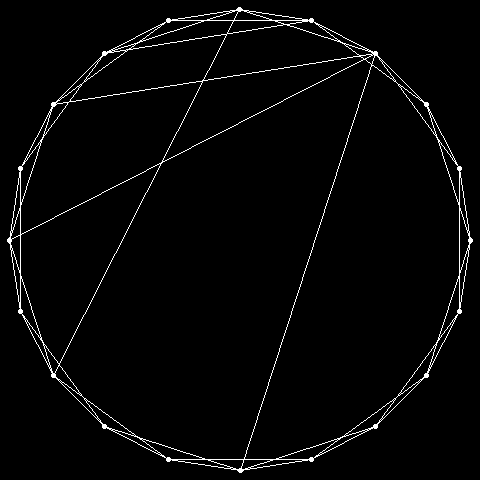

In [8]:
NetGraphics.GenerateCircleGraphImage(network, "/tmp/prueba.png")
# NetGraphics.Display("/tmp/prueba.png")